In [26]:
# Set up environment and imports
import os
import shutil
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import warnings

In [27]:
# Define constants
image_size = 128
batch_size = 32
k_folds = 5
epochs = 12
raw_dir = 'PlantVillage-Dataset/raw/color'
base_output = 'split_dataset'
test_ratio = 0.15
data_dir = 'split_dataset/train'

# Building custom CNN model

# -- Custom CNN model: data pre-processing phase --
# Split raw dataset into train/test folders (only "Tomato*" folders)
for split in ['train', 'test']:
    os.makedirs(os.path.join(base_output, split), exist_ok=True)

for class_name in os.listdir(raw_dir):
    if not class_name.startswith('Tomato'):
        continue  # Skip non-Tomato classes
    class_path = os.path.join(raw_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    train_imgs, test_imgs = train_test_split(images, test_size=test_ratio, random_state=42)

    for split, split_imgs in zip(['train', 'test'], [train_imgs, test_imgs]):
        split_class_dir = os.path.join(base_output, split, class_name)
        os.makedirs(split_class_dir, exist_ok=True)
        for img in split_imgs:
            src = os.path.join(class_path, img)
            dst = os.path.join(split_class_dir, img)
            shutil.copyfile(src, dst)

# Prepare DataFrame for training images
filepaths, labels = [], []
for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if not os.path.isdir(class_path):
        continue
    for fname in os.listdir(class_path):
        if fname.lower().endswith(('.jpg', '.jpeg', '.png')):
            filepaths.append(os.path.join(class_path, fname))
            labels.append(class_name)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})

# Encode labels
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])
num_classes = len(le.classes_)


In [28]:
# -- Custom CNN model: model building and training phase --
# Set up K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
datagen = ImageDataGenerator(rescale=1./255)  # rescaling (normalisation)
warnings.filterwarnings('ignore')

for fold, (train_idx, val_idx) in enumerate(skf.split(df['filepath'], df['encoded_label'])):
    print(f"\n--- Fold {fold+1} ---")
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    # Training data generator
    train_gen = datagen.flow_from_dataframe(
        train_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True,
        seed=42
    )

    # Validation data generator
    val_gen = datagen.flow_from_dataframe(
        val_df,
        x_col='filepath',
        y_col='label',
        target_size=(image_size, image_size),
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    # Custom CNN model
    model = Sequential([
        Input(shape=(image_size, image_size, 3)),
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    model.fit(train_gen, validation_data=val_gen, epochs=epochs)

# Prepare test set (unchanged)
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    'split_dataset/test',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


--- Fold 1 ---
Found 13117 validated image filenames belonging to 10 classes.
Found 2315 validated image filenames belonging to 10 classes.
Epoch 1/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 68s 164ms/step - accuracy: 0.4864 - loss: 1.5158 - val_accuracy: 0.7572 - val_loss: 0.6999
Epoch 2/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 68s 167ms/step - accuracy: 0.7618 - loss: 0.6990 - val_accuracy: 0.8467 - val_loss: 0.4516
Epoch 3/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 70s 171ms/step - accuracy: 0.8099 - loss: 0.5505 - val_accuracy: 0.8717 - val_loss: 0.3914
Epoch 4/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 80s 194ms/step - accuracy: 0.8391 - loss: 0.4837 - val_accuracy: 0.8834 - val_loss: 0.3521
Epoch 5/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 84s 205ms/step - accuracy: 0.8608 - loss: 0.4049 - val_accuracy: 0.9076 - val_loss: 0.2644
Epoch 6/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.8885 - loss: 0.3197 - val_accuracy: 0.9119 - val_loss: 0.2767
Epoch 7/12
410/410 ━━━━━━━━━━━━━━━━━━━━ 81s 198ms/step - accuracy: 0.9058

Found 15432 validated image filenames belonging to 10 classes.
Epoch 1/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 72s 148ms/step - accuracy: 0.9467 - loss: 0.1662
Epoch 2/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 92s 190ms/step - accuracy: 0.9584 - loss: 0.1295
Epoch 3/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 117s 243ms/step - accuracy: 0.9516 - loss: 0.1478
Epoch 4/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 94s 194ms/step - accuracy: 0.9601 - loss: 0.1167
Epoch 5/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 94s 194ms/step - accuracy: 0.9658 - loss: 0.1042
Epoch 6/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 91s 189ms/step - accuracy: 0.9558 - loss: 0.1364
Epoch 7/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 92s 191ms/step - accuracy: 0.9678 - loss: 0.0843
Epoch 8/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 93s 192ms/step - accuracy: 0.9719 - loss: 0.0818
Epoch 9/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 92s 190ms/step - accuracy: 0.9639 - loss: 0.1005
Epoch 10/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 93s 193ms/step - accuracy: 0.9659 - loss: 0.0964
Epoch 11/12
483/483 ━━━━━━━━━━━━━━━━━━━━ 94s 

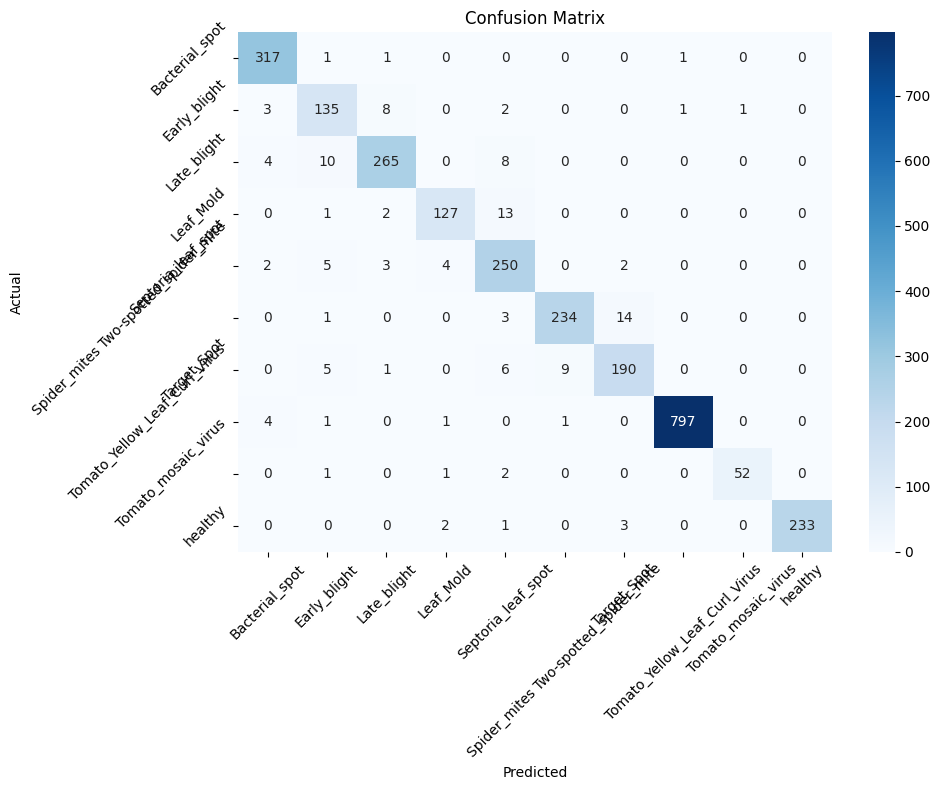

                                      precision    recall  f1-score   support

                      Bacterial_spot       0.96      0.99      0.98       320
                        Early_blight       0.84      0.90      0.87       150
                         Late_blight       0.95      0.92      0.93       287
                           Leaf_Mold       0.94      0.89      0.91       143
                  Septoria_leaf_spot       0.88      0.94      0.91       266
Spider_mites Two-spotted_spider_mite       0.96      0.93      0.94       252
                         Target_Spot       0.91      0.90      0.90       211
       Tomato_Yellow_Leaf_Curl_Virus       1.00      0.99      0.99       804
                 Tomato_mosaic_virus       0.98      0.93      0.95        56
                             healthy       1.00      0.97      0.99       239

                            accuracy                           0.95      2728
                           macro avg       0.94      0.94     

In [29]:
# -- Custom CNN model: testing and evaluation phase --
# Re-train on full training set (excluding test set)
full_train_gen = datagen.flow_from_dataframe(
    df,
    x_col='filepath',
    y_col='label',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True
)
model.fit(full_train_gen, epochs=epochs)

# Predict labels on test data
predictions = model.predict(test_generator)
y_pred = np.argmax(predictions, axis=1)

# True labels
y_true = test_generator.classes

# Get class labels (in correct order)
class_labels = [label.replace("Tomato___", "") for label in test_generator.class_indices.keys()]

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

# Generate classification report
report = classification_report(y_true, y_pred, target_names=class_labels, output_dict=True)

# Convert to DataFrame for nicer formatting
report_df = pd.DataFrame(report).transpose()

print(classification_report(y_true, y_pred, target_names=class_labels))

In [31]:
# Deploying SVM and RF based on refined data from pre-trained CNN model - ResNet50
# set up environment and imports
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm

In [32]:
# define constants
raw_dir = 'PlantVillage-Dataset/raw/color'
classes = sorted(os.listdir(raw_dir))
# Keep only tomato classes
classes = [c for c in classes if c.startswith('Tomato')]
image_size = 224
batch_size = 32
n_splits = 5
filepaths = []
labels = []

for label in classes:
    if not label.startswith('Tomato'):
        continue
    class_dir = os.path.join(raw_dir, label)
    for fname in os.listdir(class_dir):
        filepaths.append(os.path.join(class_dir, fname))
        labels.append(label)

df = pd.DataFrame({'filepath': filepaths, 'label': labels})
# Create factorized labels with index mapping
df['encoded_label'], uniques = pd.factorize(df['label'])
# Match clean class names to encoding order
clean_class_names = [label.replace('Tomato___', '') for label in uniques]

# Load ResNet50 without top layer
resnet_model = ResNet50(weights='imagenet', include_top=False, pooling='avg', input_shape=(image_size, image_size, 3))

def extract_features(img_paths):
    features = []
    for path in tqdm(img_paths, desc="Extracting features"):
        img = load_img(path, target_size=(image_size, image_size))
        img_array = img_to_array(img)
        img_array = preprocess_input(img_array)
        features.append(img_array)
    features = np.array(features)
    return resnet_model.predict(features, batch_size=batch_size)

# Precompute features
X = extract_features(df['filepath'].values)
y = df['encoded_label'].values
X_train_full, X_test, y_train_full, y_test = train_test_split(X, y, test_size=test_ratio, stratify=y, random_state=42)

# K-Fold Cross-Validation
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

Extracting features: 100%|██████████| 18160/18160 [00:17<00:00, 1050.93it/s]


568/568 ━━━━━━━━━━━━━━━━━━━━ 673s 1s/step



--- Fold 1 ---
SVM Accuracy: 0.9845

--- Fold 2 ---
SVM Accuracy: 0.9851

--- Fold 3 ---
SVM Accuracy: 0.9854

--- Fold 4 ---
SVM Accuracy: 0.9851

--- Fold 5 ---
SVM Accuracy: 0.9857
SVM Test Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       1.00      1.00      1.00       319
                        Early_blight       0.98      0.96      0.97       150
                         Late_blight       0.99      0.99      0.99       286
                           Leaf_Mold       1.00      0.99      0.99       143
                  Septoria_leaf_spot       1.00      0.98      0.99       266
Spider_mites Two-spotted_spider_mite       0.98      0.98      0.98       251
                         Target_Spot       0.96      0.98      0.97       211
       Tomato_Yellow_Leaf_Curl_Virus       1.00      1.00      1.00       803
                 Tomato_mosaic_virus       0.98      1.00      0.99        56
                 

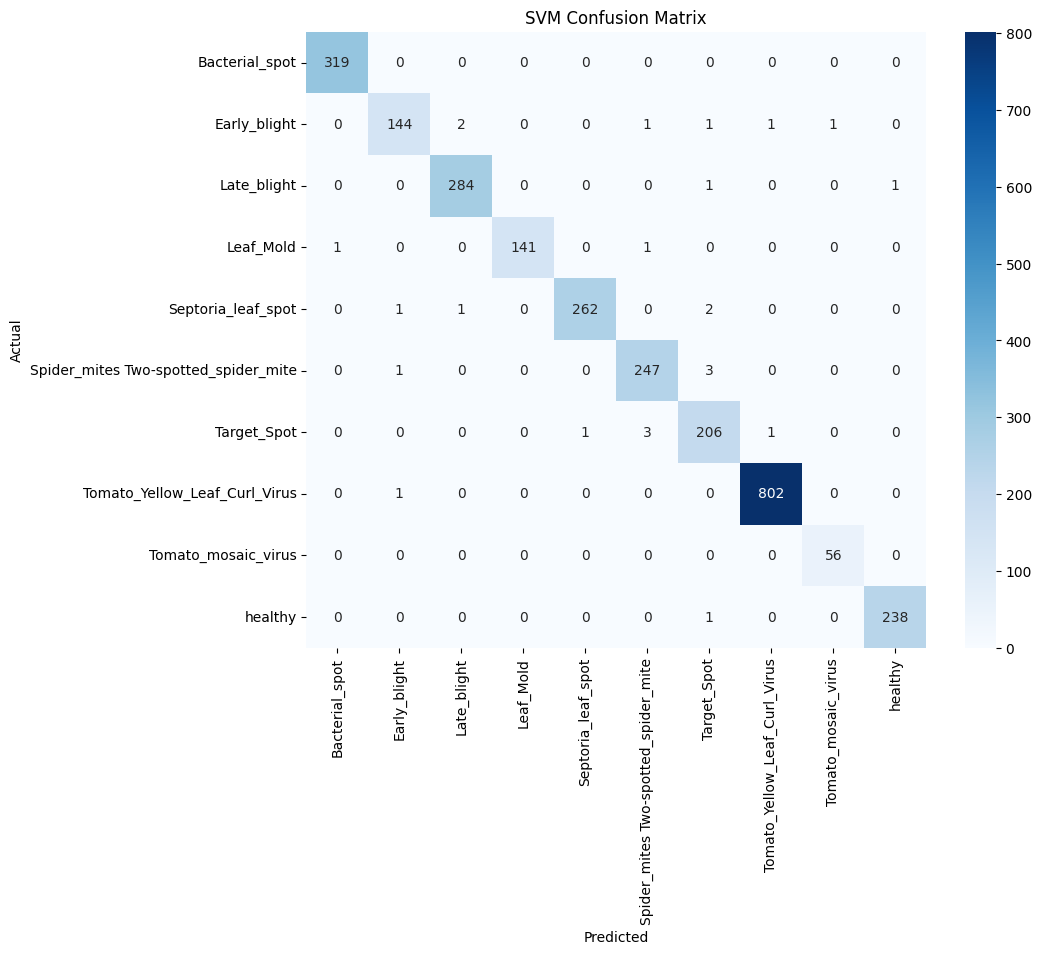

In [34]:
# -- SVM model --
svm_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]

    svm = SVC(C=5, probability=True)
    svm.fit(X_train, y_train)
    y_pred_svm = svm.predict(X_val)
    acc_svm = accuracy_score(y_val, y_pred_svm)
    svm_scores.append(acc_svm)
    print(f"SVM Accuracy: {acc_svm:.4f}")

# Final evaluation on test set
final_svm = SVC(C=5, probability=True)
final_svm.fit(X_train_full, y_train_full)
y_test_pred_svm = final_svm.predict(X_test)
print("SVM Test Report:")
print(classification_report(y_test, y_test_pred_svm, target_names=clean_class_names))
# Confusion Matrix for SVM
cm_svm = confusion_matrix(y_test, y_test_pred_svm)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("SVM Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


--- Fold 1 ---
RF Accuracy: 0.9019

--- Fold 2 ---
RF Accuracy: 0.9103

--- Fold 3 ---
RF Accuracy: 0.9025

--- Fold 4 ---
RF Accuracy: 0.9009

--- Fold 5 ---
RF Accuracy: 0.9083
RF Test Report:
                                      precision    recall  f1-score   support

                      Bacterial_spot       0.88      0.97      0.93       319
                        Early_blight       0.99      0.44      0.61       150
                         Late_blight       0.89      0.96      0.93       286
                           Leaf_Mold       0.93      0.80      0.86       143
                  Septoria_leaf_spot       0.88      0.91      0.90       266
Spider_mites Two-spotted_spider_mite       0.86      0.94      0.90       251
                         Target_Spot       0.86      0.84      0.85       211
       Tomato_Yellow_Leaf_Curl_Virus       0.96      1.00      0.98       803
                 Tomato_mosaic_virus       0.96      0.77      0.85        56
                       

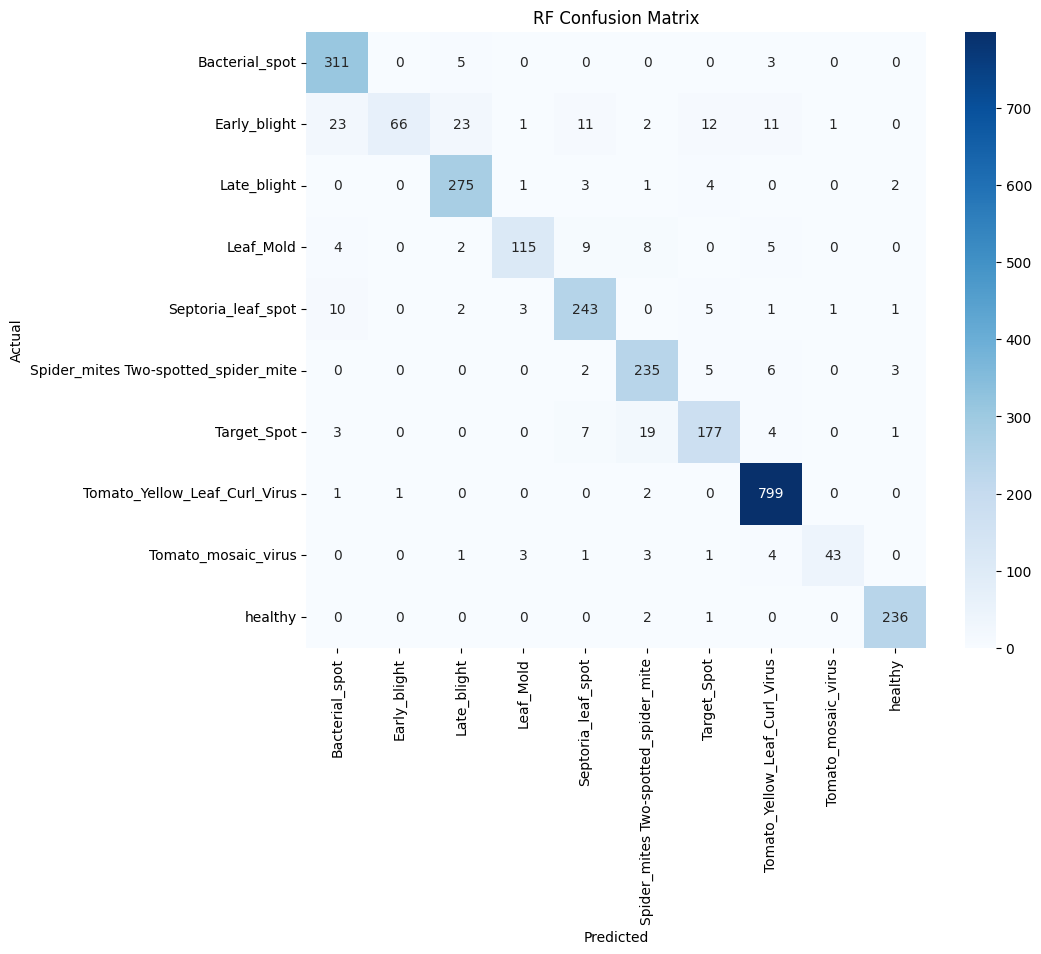

In [35]:
# -- RF model --
rf_scores = []
for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_full, y_train_full)):
    print(f"\n--- Fold {fold + 1} ---")
    X_train, X_val = X_train_full[train_idx], X_train_full[val_idx]
    y_train, y_val = y_train_full[train_idx], y_train_full[val_idx]
    
    rf = RandomForestClassifier(n_estimators=500, random_state=42)
    rf.fit(X_train, y_train)
    y_pred_rf = rf.predict(X_val)
    acc_rf = accuracy_score(y_val, y_pred_rf)
    rf_scores.append(acc_rf)
    print(f"RF Accuracy: {acc_rf:.4f}")

# Final evaluation on test set
final_rf = RandomForestClassifier(n_estimators=500, random_state=42)
final_rf.fit(X_train_full, y_train_full)
y_test_pred_rf = final_rf.predict(X_test)
print("RF Test Report:")
print(classification_report(y_test, y_test_pred_rf, target_names=clean_class_names))
# Confusion Matrix for RF
cm_rf = confusion_matrix(y_test, y_test_pred_rf)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Blues',
            xticklabels=clean_class_names, yticklabels=clean_class_names)
plt.title("RF Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()